In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from scipy.stats import gamma, uniform

In [174]:
disasters = genfromtxt('disasters.csv', delimiter = ',')

#Calculate transition probability, based on random walk proposal
def calc_probability_random_walk(tau, breakpoints_current, breakpoints_propose, labda):
    
    # Check if sorted
    if np.all(breakpoints_propose[:-1] <= breakpoints_propose[1:]):
        
        nt_current = np.histogram(tau, bins = breakpoints_current)[0].astype('int32')
        nt_propose = np.histogram(tau, bins = breakpoints_propose)[0].astype('int32')
        
        log_prob_current = (- np.sum(labda*np.diff(breakpoints_current)) 
                            + np.sum(nt_current*np.log(labda)))
        
        log_prob_propose = (-np.sum(labda*np.diff(breakpoints_propose)) 
                            + np.sum(nt_propose*np.log(labda)))
               
        return np.minimum(1, np.exp(log_prob_propose - log_prob_current))
    
    else:
        return 0 
    
#Propose moving one single breakpoint
def proposal_random_walk(breakpoints, index, rho):
    
    ti = breakpoints[index]
    R = rho*(breakpoints[index+1] - breakpoints[index-1])
    epsilon = np.random.uniform(-R, R)
    ti_proposal = ti + epsilon
    
    return ti_proposal

def sample_lambdas(tau, theta, breakpoints, num_breakpoints):
    
    nt_current = np.histogram(tau, bins = breakpoints)[0].astype('int32')
    diff = np.diff(breakpoints)
    
    sample_lambda = lambda i: np.random.gamma(2 + nt_current[i], 1/(theta + diff[i]))
    
    lambdas = np.apply_along_axis(sample_lambda, 0, np.arange(0, num_breakpoints + 1))
    
    return lambdas
    
def sample_theta(psi, labdas, num_breakpoints):
    
    theta = np.random.gamma(2 + 2*(num_breakpoints + 1), 1/(psi + np.sum(labdas)))
    
    return theta
    
    
def init_mcmc(N, num_breakpoints, psi, rho, burn_in = 0, print_debug = False):
    
    #Initial burn in attempts if needed
    M = N + burn_in
    
    #Initialize arrays
    breakpoints = np.zeros((M, num_breakpoints + 2))
    breakpoints[0] = np.arange(1658,1981, (1980-1658)/(num_breakpoints+1))
    tau = disasters  

    #Arrays to save values of lambda and theta
    lambdas = np.zeros((M, num_breakpoints + 1))
    thetas = np.zeros(M)
    
    #Array to save MH probability
    probs = np.zeros(M)
    accepts = np.zeros(M)
    
    #Initialize theta and lambda by prior distribution
    thetas[0] = np.random.gamma(2, 1/psi)
    
    for interval in range(num_breakpoints + 1):
        lambdas[0, interval] = np.random.gamma(2, 1/thetas[0])
    
    #Main loop
    for index in range(M - 1):
        
        #Gibbs sampling
        thetas[index + 1] = sample_theta(psi, lambdas[index], num_breakpoints)
        lambdas[index + 1] = sample_lambdas(tau, thetas[index + 1], breakpoints[index], num_breakpoints)

        
        #Random walk proposal for breakpoints (MH Sampling)
        breakpoints_propose = np.copy(breakpoints[index])
        
        #Propose one breakpoint at a time
        for t in np.arange(num_breakpoints) + 1:
            
            #Propose new breakpoint
            breakpoints_propose[t] = proposal_random_walk(breakpoints[index], t, rho)

        #Probability of accept
        probs[index] = calc_probability_random_walk(tau, breakpoints[index], breakpoints_propose, lambdas[index + 1])

        accept = np.random.uniform(0,1) < probs[index]
        accepts[index] = accept

        if print_debug:
            print(f'Iter: {index}')
            print(f' Theta: {thetas[index]}')
            print(f' Lambda: {lambdas[index]}')
            print(f'Breakpoint {t}')
            print(f' Current breakpoints: {breakpoints[index]}')
            print(f' Proposed breakpoints: {breakpoints_propose}')
            print(f' P(accept) = {probs[index]}')
            print(f' Accept: {accept}')
            print('____________________________________________________________')

        if accept:
            breakpoints[index + 1] = np.copy(breakpoints_propose)
        else:
            breakpoints[index+1] = np.copy(breakpoints[index])

    return breakpoints[burn_in:], lambdas[burn_in:], probs[burn_in:], accepts[burn_in:]
    

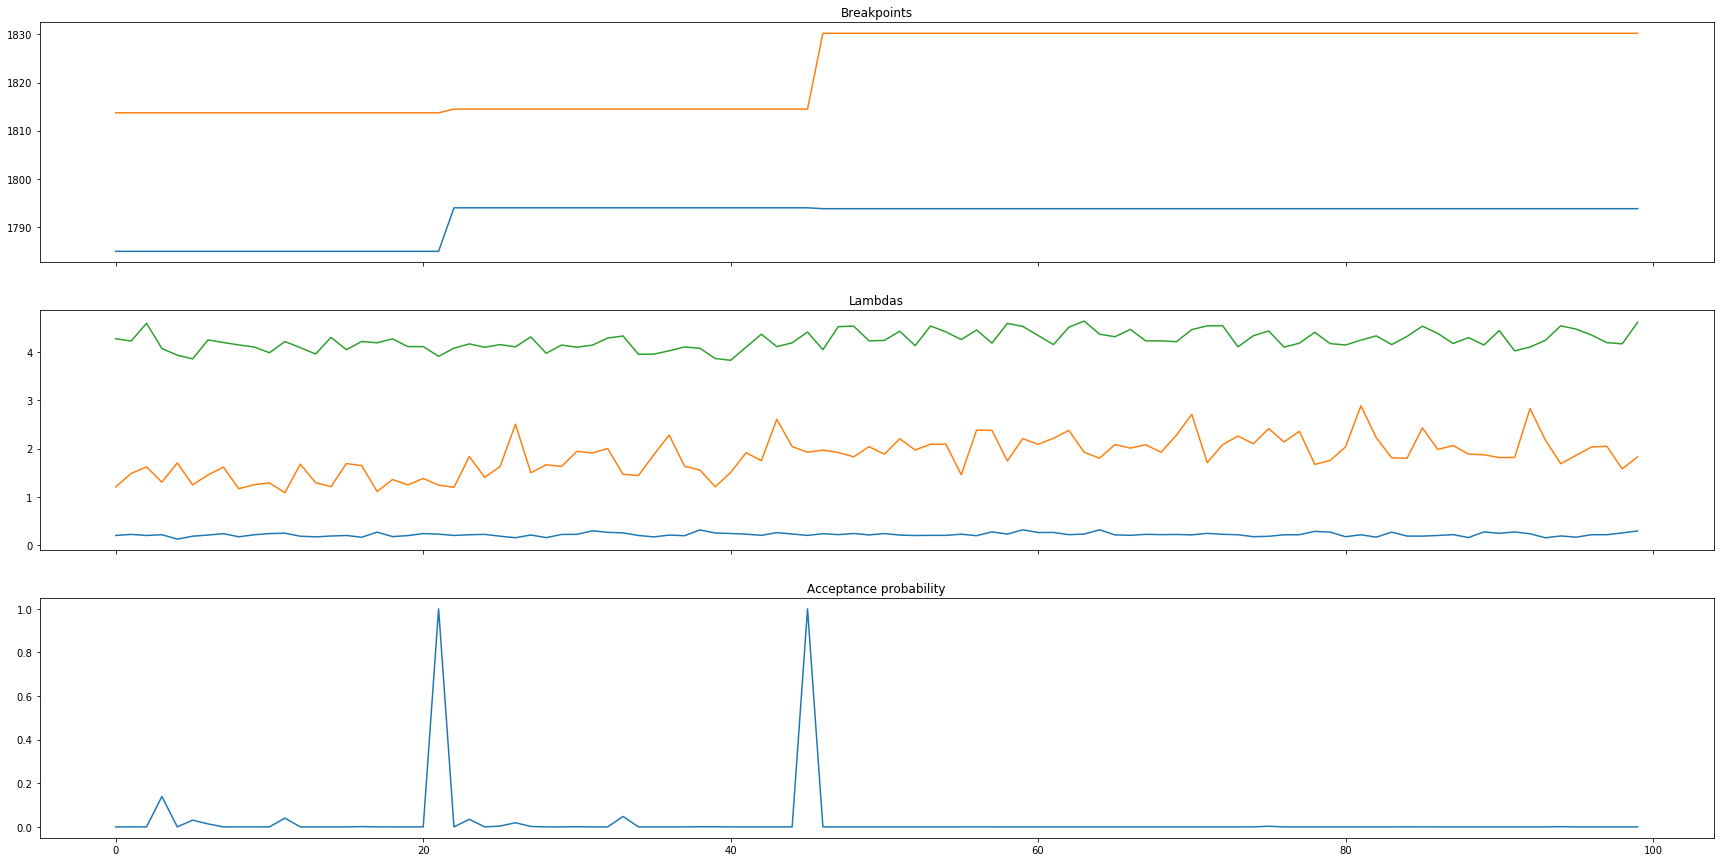

In [231]:
breakpoints, lambdas, probs, accepts = init_mcmc(N = 100, num_breakpoints = 2, psi = 0.5, rho = 0.1 ,burn_in = 200, print_debug = False)
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (30,15), sharex = True)
ax1.plot(breakpoints[:, 1:-1])
ax1.set_title("Breakpoints")
ax2.plot(lambdas)
ax2.set_title("Lambdas")
ax3.plot(probs)
ax3.set_title("Acceptance probability")
plt.show()

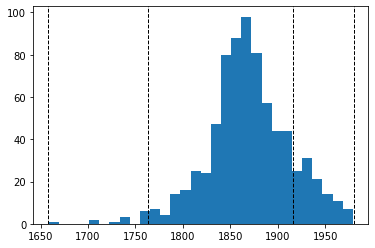

In [229]:
plt.hist(disasters, bins = 'auto')
for breakpoint in breakpoints[-1]:
    plt.axvline(breakpoint, color='k', linestyle='dashed', linewidth=1)


In [230]:
np.sum(accepts)/len(accepts)

0.24

In [76]:
breakpoints[-1]

array([1658.        , 1812.79975172, 1913.95870936, 1980.        ])

In [34]:
gamma.rvs()

AttributeError: 'int' object has no attribute 'rvs'

In [94]:
a = np.array([1, 2, 3, 4, 5])

a1 = a[1:]
a2 = a[:-1]

In [95]:
np.all(a2 >= a1)

False

In [ ]:
a2